# **Redes Neuronales Convolucionales (CNN)**

#### Usaremos Tensorflow para crear una red neuronal que es capaz de clasificar si un melanoma es benigno o maligno, ayudando así en la toma de decisiones a los doctores.

Comenzamos importando todas las dependecias necesarias para el correcto funcionamiento del documento.

In [54]:
# Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Manipulación de matrices y cálculos matemáticos
import math
import numpy as np

# Manejo de archivos y directorios
import os

# Preprocesamiento de imágenes y modelado
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2

# Métricas de evaluación
from sklearn.metrics import confusion_matrix

## Exploración y preparación de datos

Antes de desarrollar nuestra red neuronal, exploramos el conjunto de datos para comprender mejor su estructura y contenido.

In [55]:
# Función para mostrar imágenes de cada clase.

def show_images(data_folder):
    # Obtenemos los nombre de las clases (nombres de las subcarpetas dentro de data_folder).
    classes = os.listdir(data_folder)
    classes.sort()
    print(f'{len(classes)} classes:')
    print(classes)

    # Mostramos la primera imagen de cada clase.
    fig = plt.figure(figsize=(8, 15))
    for i, sub_dir in enumerate(classes, 1):
        sub_dir_path = os.path.join(data_folder, sub_dir)
        img_files = [f for f in os.listdir(sub_dir_path) if f.endswith('.png') or f.endswith('.jpg')]
        if len(img_files) == 0:
            continue
        img_file = img_files[0]
        img_path = os.path.join(sub_dir_path, img_file)
        img = mpimg.imread(img_path)
        a = fig.add_subplot(1, len(classes), i)
        a.axis('off')
        imgplot = plt.imshow(img)
        a.set_title(img_file)
    plt.show()

Mostramos las distintas clases que hay en nuestro set de datos.

2 classes:
['Benign', 'Malignant']


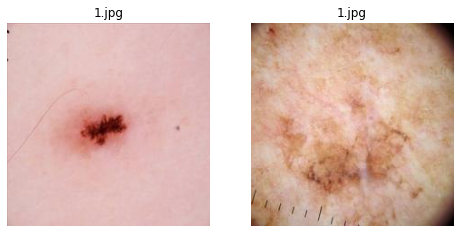

In [56]:
# Definimos la ruta donde se encuentran los datos.
data_folder = 'Cancer/train'

# Mostramos las imágenes.
show_images(data_folder)

In [57]:
# Funcón para preparar los datos de entrenamiento y validación.

def prepare_data(data_folder, img_size, batch_size):
    print("Getting Data...")
    datagen = ImageDataGenerator(rescale=1./255, # Normalizamos los valores de los píxeles para que estén en el rango [0, 1].
                                 validation_split=0.3) # Dividimos el conjunto de datos, reservando el 30% para validación.

    print("Preparing training dataset...")
    train_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True, # Barajamos los datos.
        subset='training')  # Seleccionamos subconjunto de validación.

    print("Preparing validation dataset...")
    validation_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True, # Barajamos los datos.
        subset='validation') # Seleccionamos subconjunto de validación.

    classnames = list(train_generator.class_indices.keys())
    print(f'Data generators ready. Classes: {classnames}')

    return train_generator, validation_generator, classnames

Preparamos los generadores de datos para el entrenamiento y la validación de nuestro modelo de red neuronal convolucional (CNN).

In [58]:
# Definimos el tamaño de las imágenes y el tamaño del lote.
img_size = (128, 128)
batch_size = 64
validation_split = 0.3

# Preparamos los datos de entrenamiento y validación.
train_generator, validation_generator, classnames = prepare_data(data_folder, img_size, batch_size)

Getting Data...
Preparing training dataset...
Found 8316 images belonging to 2 classes.
Preparing validation dataset...
Found 3563 images belonging to 2 classes.
Data generators ready. Classes: ['Benign', 'Malignant']


## Modelo

Una vez hecho el pre-procesamiento de datos, definiremos y entrenaremos nuestro modelo.

In [59]:
# Función que define el modelo de red neuronal convolucional.

def build_model(train_generator):
    print("Building model...")

    # Definimos los regularizadores L1 y L2.
    l1_l2_reg = l1_l2(l1=1e-5, l2=1e-4)

    model = Sequential([ # Definimos un modelo como una secuencia de capas.
        Conv2D(32, (3, 3),  activation='relu', input_shape=train_generator.image_shape, kernel_regularizer=l1_l2_reg),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_l2_reg),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_l2_reg),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(), # Aplanar los mapas de características.
        Dense(512, activation='relu'),  # Capa adicional completamente conectada con una probabilidad predicha para cada clase.
        Dense(train_generator.num_classes, activation='softmax') # softmax asegura que todas las probabilidades sumen 1.
    ])

    # Compilar el modelo usando el optimizador Adam para clasificación categórica (multiclase).
    model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model

In [60]:
# Función para entrenar el modelo.

def train_model(model, train_generator, validation_generator, num_epochs):
    print("Training model...")

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=num_epochs
    )
    return history

In [61]:
# Construimos el modelo.
model = build_model(train_generator)

# Entrenamos el modelo.
num_epochs = 95
history = train_model(model, train_generator, validation_generator, num_epochs)

Building model...


C:\Users\Laura Rodríguez\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,194 (12.33 MB)

 Trainable params: 3,232,194 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/95


C:\Users\Laura Rodríguez\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.5558 - loss: 0.7000 - val_accuracy: 0.5293 - val_loss: 0.6960
Epoch 2/95
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6875 - loss: 0.6488 - val_accuracy: 0.6279 - val_loss: 0.6763
Epoch 3/95


c:\ProgramData\Anaconda3\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - accuracy: 0.5243 - loss: 0.6878 - val_accuracy: 0.5423 - val_loss: 0.6898
Epoch 4/95
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - accuracy: 0.6250 - loss: 0.6564 - val_accuracy: 0.5116 - val_loss: 0.7008
Epoch 5/95
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 0.5686 - loss: 0.6747 - val_accuracy: 0.5645 - val_loss: 0.6836
Epoch 6/95
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - accuracy: 0.5469 - loss: 0.6785 - val_accuracy: 0.6744 - val_loss: 0.6407
Epoch 7/95
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.6146 - loss: 0.6649 - val_accuracy: 0.5688 - val_loss: 0.6763
Epoch 8/95
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step - accuracy: 0.6406 - loss: 0.6414 - val_accuracy: 0.5116 - val_loss: 0.6983
Epoch 9/95
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.6370 - loss: 0.6499 - val_accuracy: 0.6003 - val_loss: 0.6659
Epoch 10/95
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - accuracy: 0.6562 - loss: 0.6418 - val_ac

## Evaluación

In [62]:
# Función para graficar la curva de aprendizaje.

def plot_loss(history, num_epochs):
    epoch_nums = range(1, num_epochs + 1)
    training_loss = history.history["loss"]
    validation_loss = history.history["val_loss"]
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.tight_layout()
    #plt.savefig('img/learning_curve_cnn.png')
    plt.show()

In [63]:
# Función para evaluar el modelo y mostrar matriz de confusión.

def evaluate_model(model, validation_generator, classes):
    print("Generating predictions from validation data...")

    # Obtenemos los arrays de imágenes y etiquetas del primer lote de datos de validación.
    x_test = validation_generator[0][0]
    y_test = validation_generator[0][1]

    # Utilizar el modelo para predecir la clase.
    class_probabilities = model.predict(x_test)

    # Obtenemos la clase predicha para cada imagen.
    predictions = np.argmax(class_probabilities, axis=1)

    # Las etiquetas reales están codificadas en caliente (one-hot encoded), así que obtenemos la clase con el valor 1.
    true_labels = np.argmax(y_test, axis=1)

    # Mostramos la matriz de confusión.
    cm = confusion_matrix(true_labels, predictions)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Mostramos métricas de evaluación del modelo.
    print("Evaluating model accuracy...")
    test_loss, test_accuracy = model.evaluate(validation_generator)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_accuracy)

Una vez entrenado el modelo, podemos visualizar su pérdida de entrenamiento y validación a lo largo de las épocas. También podemos visualizar una matriz de confusión que muestre las predicciones del modelo sobre los datos de validación.

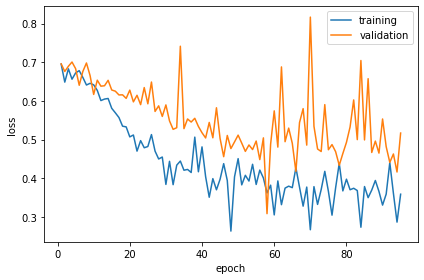

Generating predictions from validation data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


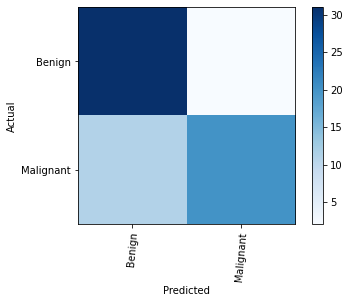

Evaluating model accuracy...
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.7559 - loss: 0.5067
Test loss: 0.5173850655555725
Test accuracy: 0.7527364492416382


In [64]:
# Graficamos la curva de aprendizaje.
plot_loss(history, num_epochs)

# Evaluamos el modelo y mostramos la matriz de confusión.
evaluate_model(model, validation_generator, classnames)

In [65]:
'''
# Save the trained model
modelFileName = '../modelos/logo_classifier.keras'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)
'''

"\n# Save the trained model\nmodelFileName = '../modelos/logo_classifier.keras'\nmodel.save(modelFileName)\ndel model  # deletes the existing model variable\nprint('model saved as', modelFileName)\n"